Problem 1

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Files already downloaded and verified

Training Simple MLP Model:
Epoch [1/20], Train Loss: 1.7288, Val Loss: 1.5461, Train Acc: 39.04%, Val Acc: 44.60%
Epoch [2/20], Train Loss: 1.4850, Val Loss: 1.4702, Train Acc: 46.97%, Val Acc: 47.44%
Epoch [3/20], Train Loss: 1.3842, Val Loss: 1.4177, Train Acc: 50.77%, Val Acc: 49.56%
Epoch [4/20], Train Loss: 1.3117, Val Loss: 1.3901, Train Acc: 53.04%, Val Acc: 50.36%
Epoch [5/20], Train Loss: 1.2529, Val Loss: 1.3757, Train Acc: 55.19%, Val Acc: 51.15%
Epoch [6/20], Train Loss: 1.2046, Val Loss: 1.3833, Train Acc: 56.88%, Val Acc: 51.01%
Epoch [7/20], Train Loss: 1.1645, Val Loss: 1.3444, Train Acc: 58.37%, Val Acc: 52.50%
Epoch [8/20], Train Loss: 1.1218, Val Loss: 1.3630, Train Acc: 59.88%, Val Acc: 52.05%
Epoch [9/20], Train Loss: 1.0900, Val Loss: 1.3678, Train Acc: 60.73%, Val Acc: 52.33%
Epoch [10/20], Train Loss: 1.0521, Val Loss: 1.3682, Train Acc: 62.33%, Val Acc: 52.64%
Epoch [11/20], Train Loss: 1.0217, Val Loss:

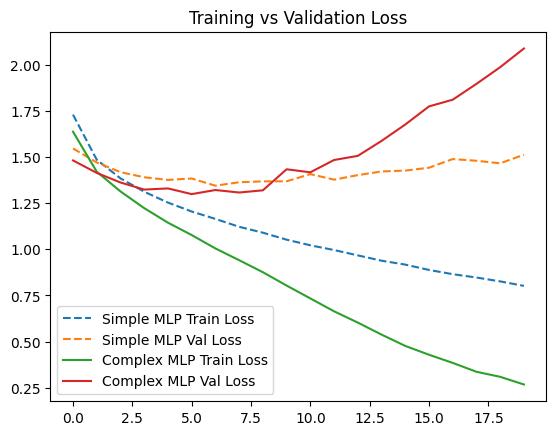

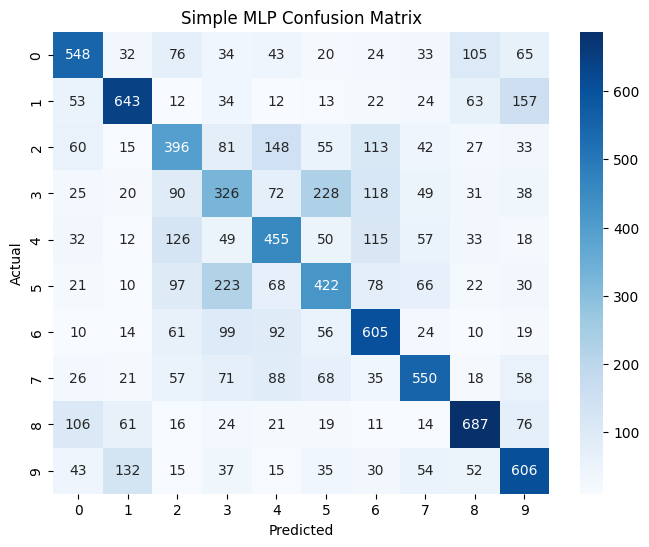

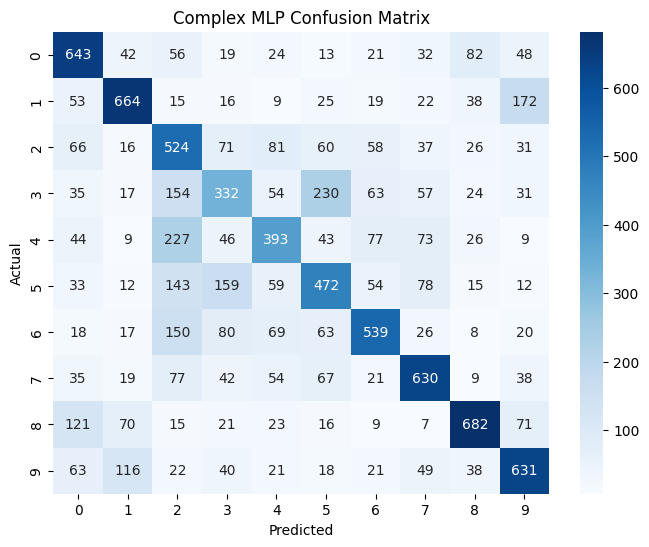


Observations:
- The simple model generalizes better with lower validation loss.
- Overfitting is evident as training loss is much lower, but validation loss is higher.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_data, val_data = torch.utils.data.random_split(trainset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=True)

# Define MLP Variations
class MLP(nn.Module):
    def __init__(self, input_size=3072, hidden_sizes=[256, 128, 64], output_size=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

class ComplexMLP(MLP):
    def __init__(self):
        super().__init__(hidden_sizes=[1024, 512, 256])  # Increased width and depth

class SimpleMLP(MLP):
    def __init__(self):
        super().__init__(hidden_sizes=[128, 64])  # Decreased width and depth

# Training Function
def train(model, train_loader, val_loader, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        correct, total, val_epoch_loss = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(val_epoch_loss / len(val_loader))
        val_acc.append(100 * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%")

    return train_loss, val_loss, train_acc, val_acc

# Train and Compare Simple and Complex Models
simple_model = SimpleMLP().to(device)
complex_model = ComplexMLP().to(device)

print("\nTraining Simple MLP Model:")
simple_train_loss, simple_val_loss, simple_train_acc, simple_val_acc = train(simple_model, train_loader, val_loader)

print("\nTraining Complex MLP Model:")
complex_train_loss, complex_val_loss, complex_train_acc, complex_val_acc = train(complex_model, train_loader, val_loader)

# Plot Loss Comparison
plt.plot(simple_train_loss, label="Simple MLP Train Loss", linestyle="--")
plt.plot(simple_val_loss, label="Simple MLP Val Loss", linestyle="--")
plt.plot(complex_train_loss, label="Complex MLP Train Loss")
plt.plot(complex_val_loss, label="Complex MLP Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Function for Confusion Matrix
def plot_confusion_matrix(model, val_loader, title="Confusion Matrix"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Confusion Matrices for Simple and Complex Models
plot_confusion_matrix(simple_model, val_loader, "Simple MLP Confusion Matrix")
plot_confusion_matrix(complex_model, val_loader, "Complex MLP Confusion Matrix")

# Print Observations on Overfitting
print("\nObservations:")
if complex_train_acc[-1] > simple_train_acc[-1] and complex_val_acc[-1] < simple_val_acc[-1]:
    print("- The complex model achieves much higher training accuracy but lower validation accuracy, indicating overfitting.")
if simple_val_loss[-1] < complex_val_loss[-1]:
    print("- The simple model generalizes better with lower validation loss.")
if complex_train_loss[-1] < simple_train_loss[-1] and complex_val_loss[-1] > simple_val_loss[-1]:
    print("- Overfitting is evident as training loss is much lower, but validation loss is higher.")



In [ ]:
from sklearn.metrics import classification_report

# Function to Compute Metrics
def evaluate_model(model, val_loader, model_name="Model"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, digits=4))

# Evaluate Both Models
evaluate_model(simple_model, val_loader, "Simple MLP")
evaluate_model(complex_model, val_loader, "Complex MLP")


Problem 2

Using device: cuda

Training Model for 2.a (No One-Hot Encoding):
Epoch [1/100], Train Loss: 0.8439, Val Loss: 0.9797


C:\Users\mukoo\AppData\Local\Temp\ipykernel_5332\2466053633.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == "yes" else 0)


Epoch [2/100], Train Loss: 0.6079, Val Loss: 0.6397
Epoch [3/100], Train Loss: 0.4707, Val Loss: 0.5614
Epoch [4/100], Train Loss: 0.4382, Val Loss: 0.5487
Epoch [5/100], Train Loss: 0.3686, Val Loss: 0.5374
Epoch [6/100], Train Loss: 0.3904, Val Loss: 0.5358
Epoch [7/100], Train Loss: 0.3980, Val Loss: 0.5327
Epoch [8/100], Train Loss: 0.3413, Val Loss: 0.5392
Epoch [9/100], Train Loss: 0.4047, Val Loss: 0.5470
Epoch [10/100], Train Loss: 0.3726, Val Loss: 0.5449
Epoch [11/100], Train Loss: 0.3538, Val Loss: 0.5197
Epoch [12/100], Train Loss: 0.3562, Val Loss: 0.5267
Epoch [13/100], Train Loss: 0.3323, Val Loss: 0.5334
Epoch [14/100], Train Loss: 0.3264, Val Loss: 0.5275
Epoch [15/100], Train Loss: 0.3176, Val Loss: 0.5164
Epoch [16/100], Train Loss: 0.3401, Val Loss: 0.5293
Epoch [17/100], Train Loss: 0.3350, Val Loss: 0.5370
Epoch [18/100], Train Loss: 0.3335, Val Loss: 0.5376
Epoch [19/100], Train Loss: 0.3357, Val Loss: 0.5298
Epoch [20/100], Train Loss: 0.3192, Val Loss: 0.5236
E

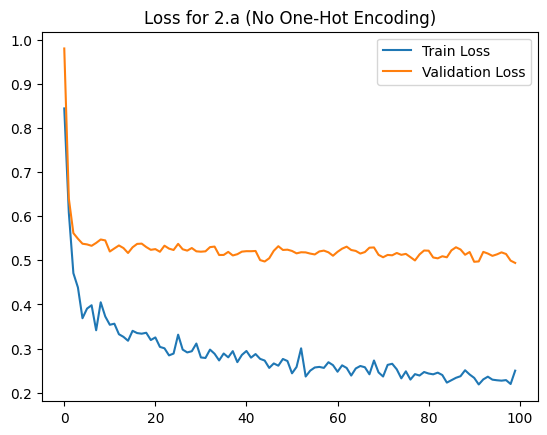


Training Model for 2.b (With One-Hot Encoding):
Epoch [1/100], Train Loss: 0.6216, Val Loss: 0.9161
Epoch [2/100], Train Loss: 0.4506, Val Loss: 0.6438
Epoch [3/100], Train Loss: 0.4053, Val Loss: 0.5859
Epoch [4/100], Train Loss: 0.4036, Val Loss: 0.5620
Epoch [5/100], Train Loss: 0.3615, Val Loss: 0.5518
Epoch [6/100], Train Loss: 0.3806, Val Loss: 0.5590
Epoch [7/100], Train Loss: 0.3744, Val Loss: 0.5434
Epoch [8/100], Train Loss: 0.3348, Val Loss: 0.5364
Epoch [9/100], Train Loss: 0.3470, Val Loss: 0.5218
Epoch [10/100], Train Loss: 0.3364, Val Loss: 0.5104
Epoch [11/100], Train Loss: 0.3429, Val Loss: 0.5182
Epoch [12/100], Train Loss: 0.3017, Val Loss: 0.5175
Epoch [13/100], Train Loss: 0.3125, Val Loss: 0.5150
Epoch [14/100], Train Loss: 0.3136, Val Loss: 0.5165
Epoch [15/100], Train Loss: 0.3209, Val Loss: 0.5238
Epoch [16/100], Train Loss: 0.2977, Val Loss: 0.5261
Epoch [17/100], Train Loss: 0.2988, Val Loss: 0.5312
Epoch [18/100], Train Loss: 0.3017, Val Loss: 0.5219
Epoch 

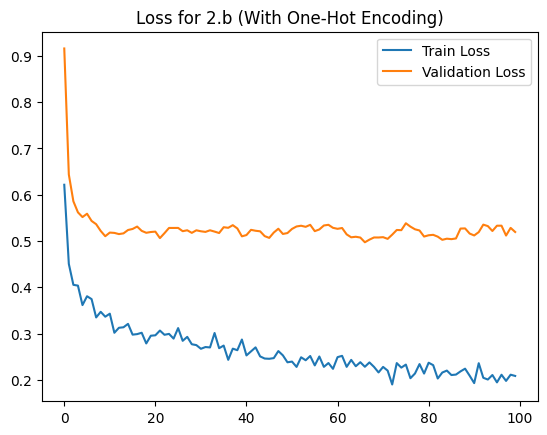


Training Model for 2.c (More Complex Architecture):
Epoch [1/100], Train Loss: 0.6124, Val Loss: 0.7475
Epoch [2/100], Train Loss: 0.3521, Val Loss: 0.5390
Epoch [3/100], Train Loss: 0.3242, Val Loss: 0.5205
Epoch [4/100], Train Loss: 0.3305, Val Loss: 0.5257
Epoch [5/100], Train Loss: 0.3156, Val Loss: 0.4966
Epoch [6/100], Train Loss: 0.3299, Val Loss: 0.4983
Epoch [7/100], Train Loss: 0.2976, Val Loss: 0.5033
Epoch [8/100], Train Loss: 0.2904, Val Loss: 0.5050
Epoch [9/100], Train Loss: 0.2622, Val Loss: 0.5019
Epoch [10/100], Train Loss: 0.2816, Val Loss: 0.5118
Epoch [11/100], Train Loss: 0.2522, Val Loss: 0.5076
Epoch [12/100], Train Loss: 0.2652, Val Loss: 0.5103
Epoch [13/100], Train Loss: 0.2593, Val Loss: 0.5019
Epoch [14/100], Train Loss: 0.2546, Val Loss: 0.5115
Epoch [15/100], Train Loss: 0.2452, Val Loss: 0.5286
Epoch [16/100], Train Loss: 0.2463, Val Loss: 0.5286
Epoch [17/100], Train Loss: 0.2417, Val Loss: 0.5195
Epoch [18/100], Train Loss: 0.2236, Val Loss: 0.5117
Ep

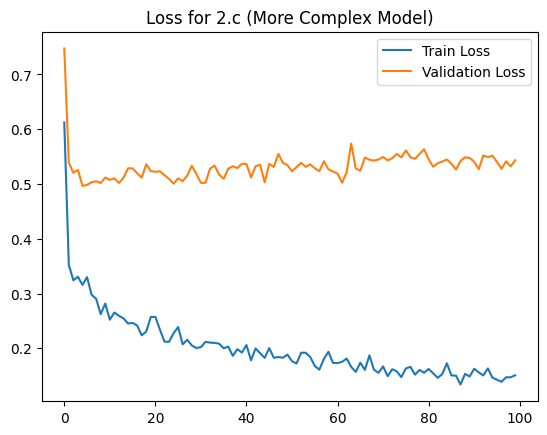

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
file_path = "Housing.csv"  # Change this if necessary
df = pd.read_csv(file_path)

# Convert categorical columns to numerical
binary_cols = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == "yes" else 0)

# Splitting dataset into features and target
X = df.drop(columns=["price", "furnishingstatus"])  # Excluding 'furnishingstatus' for 2.a
y = df["price"].values.reshape(-1, 1)  # Target variable

# Normalize features
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)  # Normalize the target price

# Train-test split (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# Define MLP Model with Dropout
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 32], output_size=1, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.drop1 = nn.Dropout(dropout_rate)  # Dropout layer (0.2)

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.drop2 = nn.Dropout(dropout_rate)  # Dropout layer (0.2)

        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)  # Apply dropout (0.2)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)  # Apply dropout (0.2)
        x = self.fc3(x)
        return x

# Training Function (Weight Decay, No Early Stopping)
def train(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, weight_decay=1e-4):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)  # L2 Regularization
    
    train_loss, val_loss = [], []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_batches = len(X_train) // batch_size

        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            inputs, targets = X_train[start:end], y_train[start:end]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / num_batches
        train_loss.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_mse = criterion(val_outputs, y_val).item()
            val_loss.append(val_mse)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_mse:.4f}")

    return train_loss, val_loss


# Train Model for 2.a (No One-Hot Encoding)
input_size = X_train.shape[1]
model_2a = MLP(input_size).to(device)

print("\nTraining Model for 2.a (No One-Hot Encoding):")
train_loss_2a, val_loss_2a = train(model_2a, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

# Plot Loss for 2.a
plt.plot(train_loss_2a, label="Train Loss")
plt.plot(val_loss_2a, label="Validation Loss")
plt.legend()
plt.title("Loss for 2.a (No One-Hot Encoding)")
plt.show()

# 2.b: One-Hot Encoding Furnishing Status
df_encoded = df.copy()
one_hot = OneHotEncoder(sparse_output=False, drop="first")
encoded_features = one_hot.fit_transform(df_encoded[["furnishingstatus"]])
df_encoded = df_encoded.drop(columns=["furnishingstatus"])
df_encoded = np.hstack((df_encoded.values, encoded_features))

# Extract features and target
X_encoded = df_encoded[:, 1:]  # Exclude price
y_encoded = df_encoded[:, 0].reshape(-1, 1)

# Normalize
X_encoded = scaler_X.fit_transform(X_encoded)
y_encoded = scaler_y.fit_transform(y_encoded)

# Train-test split
X_train_enc, X_val_enc, y_train_enc, y_val_enc = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, shuffle=True)

# Convert to PyTorch tensors
X_train_enc_tensor = torch.tensor(X_train_enc, dtype=torch.float32).to(device)
y_train_enc_tensor = torch.tensor(y_train_enc, dtype=torch.float32).to(device)
X_val_enc_tensor = torch.tensor(X_val_enc, dtype=torch.float32).to(device)
y_val_enc_tensor = torch.tensor(y_val_enc, dtype=torch.float32).to(device)

# Train Model for 2.b (With One-Hot Encoding)
input_size_enc = X_train_enc.shape[1]
model_2b = MLP(input_size_enc).to(device)

print("\nTraining Model for 2.b (With One-Hot Encoding):")
train_loss_2b, val_loss_2b = train(model_2b, X_train_enc_tensor, y_train_enc_tensor, X_val_enc_tensor, y_val_enc_tensor)

# Plot Loss for 2.b
plt.plot(train_loss_2b, label="Train Loss")
plt.plot(val_loss_2b, label="Validation Loss")
plt.legend()
plt.title("Loss for 2.b (With One-Hot Encoding)")
plt.show()

# 2.c: Increased Model Complexity
class ComplexMLP(MLP):
    def __init__(self):
        super().__init__(input_size=input_size_enc, hidden_sizes=[128, 64, 32])  # More layers

model_2c = ComplexMLP().to(device)

print("\nTraining Model for 2.c (More Complex Architecture):")
train_loss_2c, val_loss_2c = train(model_2c, X_train_enc_tensor, y_train_enc_tensor, X_val_enc_tensor, y_val_enc_tensor)

# Plot Loss for 2.c
plt.plot(train_loss_2c, label="Train Loss")
plt.plot(val_loss_2c, label="Validation Loss")
plt.legend()
plt.title("Loss for 2.c (More Complex Model)")
plt.show()
